In [1]:
%matplotlib inline
#%matplotlib qt5

# Inicialização, Otimização e Regularização

Nesta prática, veremos como a inicialização dos pesos, regularização e escolha dos otimizadores influenciam o treinamento.

Os exemplos aqui são mostrados em MLP simples (somentes camadas densas), porém os mesmos conceitos se aplicam a Redes Convolucionais.

In [2]:
# Importa módulos e funções 

import numpy as np
from random import seed, sample
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) 

from sklearn.datasets import make_classification
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers, regularizers, initializers

from matplotlib.colors import ListedColormap

Vamos definir duas funções que constróem um _dataset_ sintético, usando a função `make_classification()` do pacote [Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

In [3]:
def make_synth_dataset():
    X, Y = make_classification(n_samples = 150, n_classes=2, n_features=2, n_redundant=0, n_informative=2, class_sep=2, random_state=20)
    validIdx = sample(list(range(150)), 50)
    
    X_valid = np.array([X[i] for i in validIdx])
    Y_valid = np.array([Y[i] for i in validIdx])
    
    X_train = np.array([X[i] for i in list(range(150)) if i not in validIdx])
    Y_train = np.array([Y[i] for i in list(range(150)) if i not in validIdx])
    
    return X_train, Y_train, X_valid, Y_valid
    
def make_synth_dataset_with_noise():
    X, Y = make_classification(n_samples = 150, n_classes=2, n_features=2, n_redundant=0, n_informative=2, class_sep=2, random_state=20)
    validIdx = sample(list(range(150)), 50)
    
    X_valid = np.array([X[i] for i in validIdx])
    Y_valid = np.array([Y[i] for i in validIdx])
    
    X_train = np.array([X[i] for i in list(range(150)) if i not in validIdx])
    Y_train = np.array([Y[i] for i in list(range(150)) if i not in validIdx])

    noise_X = [ (1.5,-0.5), (1.6,-0.5),(1.4,-0.5), (1.5,-0.4),(1.5,-0.6)]
    noise_Y = [0 for sample in noise_X]

    X_train = np.concatenate((X_train, noise_X), axis=0)
    Y_train = np.concatenate((Y_train, noise_Y), axis=0)
    
    return X_train, Y_train, X_valid, Y_valid

Vamos definir também algumas funções auxiliares para visualização dos dados e resultados.

In [4]:
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()
    plt.show()
    

def plot_decision_boundary(func, X, y, title, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.title(title)
    plt.show()

    
def plot_loss_accuracy(historyList, legend, plotSet="both"):
    linestyles = ['-', '--', ':', '-.']
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    #Plot Loss
    for idx,hist in enumerate(historyList):
        if plotSet in ["train", "both"]:
            ax1.plot(hist.history['loss'], linestyle=linestyles[idx%len(linestyles)])
        if 'val_loss' in hist.history.keys() and plotSet in ["valid", "both"]:
            ax1.plot(hist.history['val_loss'], linestyle=linestyles[idx%len(linestyles)])
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    #Plot ACC
    for idx,hist in enumerate(historyList): 
        if plotSet in ["train", "both"]:
            ax2.plot(hist.history['accuracy'], linestyle=linestyles[idx%len(linestyles)])
        if 'val_accuracy' in hist.history.keys() and plotSet in ["valid", "both"]:
            ax2.plot(hist.history['val_accuracy'], linestyle=linestyles[idx%len(linestyles)])
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    
    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc='center left')    
    plt.subplots_adjust(right=0.75)
    plt.show()

## Gera dados sintéticos

Dado de Treinamento (sem ruído)


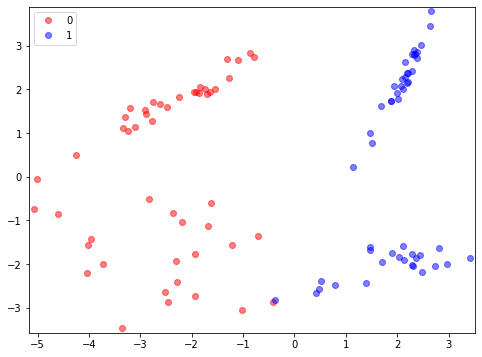

Dado de Treinamento (com ruído)


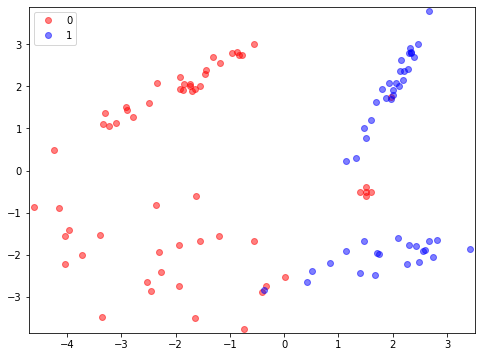

Validação


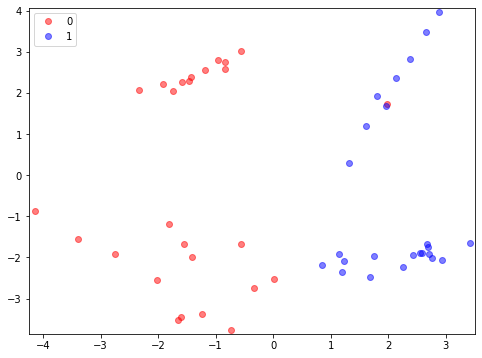

In [5]:
X_train, Y_train, X_valid, Y_valid = make_synth_dataset()
X_reg_train, Y_reg_train, X_reg_valid, Y_reg_valid = make_synth_dataset_with_noise()

print("Dado de Treinamento (sem ruído)")
plot_data(X_train, Y_train)
print("Dado de Treinamento (com ruído)")
plot_data(X_reg_train, Y_reg_train)
print("Validação")
plot_data(X_valid, Y_valid)


----------
## Inicialização dos Pesos

O método de inicialização dos pesos pode tornar a convergência da rede mais rápida ou devagar ou até mesmo inviabilizar que a rede convirja. Tipicamente, inicializamos os pesos de maneira aleatória, porém diferentes distribuições tem comportamentos diferentes. 

Keras disponibiliza diversas estratégias de [inicialização](https://keras.io/initializers). Abaixo, avaliaremos quatro estratégias:

- `zeros`: que inicializa pesos com 0.0;
- `ones`: inicializa com 1.0;
- `random_normal`: inicializa com valores sorteados na distribuição normal. Os valores padrão são média=0.0 e desvio=0.05, porém podem ser configurados, se necessário;
- `glorot_uniform`: também conhecida como inicialização Xavier. Atualmente, é a estratégia mais comumente usada e computa os limites da distribuição a partir da quantidade de _inputs_ e _outputs_ (rever _slides_ da aula 03, se necessário).

O método padrão nas camadas densas ou convolucionais do Keras é `glorot_uniform` para os pesos e `zeros` para o _bias_.

In [6]:
historyList = []
initTypes = ["zeros", "ones", "random_normal", "glorot_uniform"]
for initialization in initTypes:
    #Define o modelo
    model = Sequential()
    model.add(Dense(64, input_shape=(2,), activation='tanh', kernel_initializer = initialization))
    model.add(Dense(64, activation='tanh', kernel_initializer = initialization))
    model.add(Dense(64, activation='tanh', kernel_initializer = initialization))
    model.add(Dense(64, activation='tanh', kernel_initializer = initialization))
    model.add(Dense(1, activation='sigmoid', kernel_initializer = initialization))

    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    historyList.append(model.fit(X_train, Y_train, epochs=200, verbose=0, validation_data=(X_valid, Y_valid)))


In [7]:
print(historyList)

[<keras.callbacks.History object at 0x7ff6e008ae50>, <keras.callbacks.History object at 0x7ff66f2ef550>, <keras.callbacks.History object at 0x7ff66f0c2250>, <keras.callbacks.History object at 0x7ff66eff1390>]


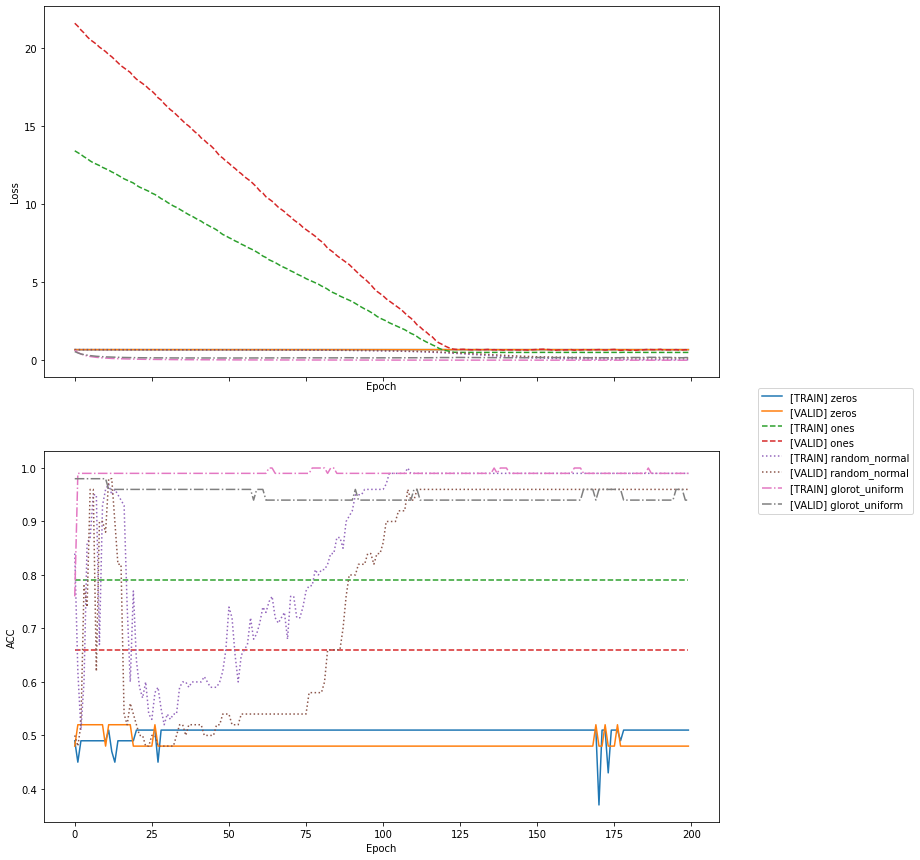

In [8]:
legend = ["[TRAIN] zeros", "[VALID] zeros", 
          "[TRAIN] ones", "[VALID] ones", 
          "[TRAIN] random_normal", "[VALID] random_normal",
          "[TRAIN] glorot_uniform", "[VALID] glorot_uniform"]

plot_loss_accuracy(historyList, legend, plotSet='both')

----------
## Otimizadores

Keras também disponibiliza diversos [otimizadores](https://keras.io/optimizers/), cada um deles com diversos hiperparâmetros, desafios para encontrar valores ótimos e situações onde cada um tem melhor desempenho (leia a documentação para detalhes).

Neste exemplo, veremos quatro exemplos: **Stochastic Gradient Descent (SGD)**, **Adam**, **Adagrad** e **RMSprop**. Todos eles baseiam-se no conceito de **descida de gradiente**.

In [9]:
historyList = []
optimizers = ["sgd", "adam","adagrad", "rmsprop"]
for opt in optimizers:
    #Define o modelo
    model = Sequential()
    model.add(Dense(20, input_shape=(2,), activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    historyList.append(model.fit(X_train, Y_train, epochs=20, verbose=0, validation_data=(X_valid, Y_valid)))    

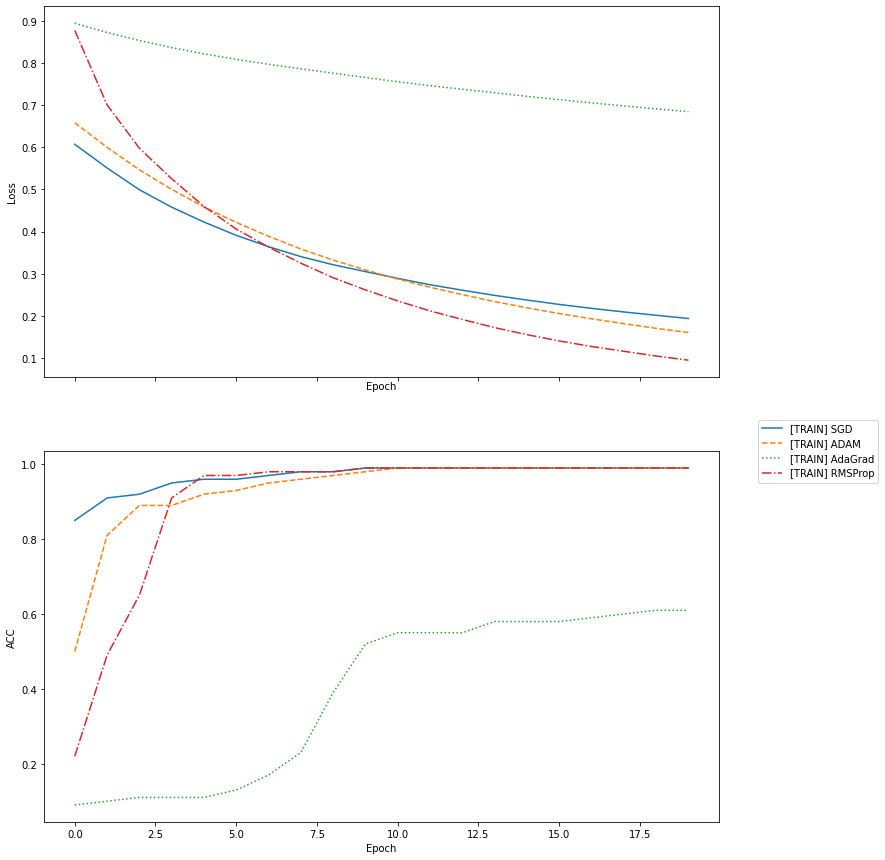

In [10]:
legend = ["[TRAIN] SGD", "[TRAIN] ADAM", "[TRAIN] AdaGrad", "[TRAIN] RMSProp"]
plot_loss_accuracy(historyList, legend, "train")

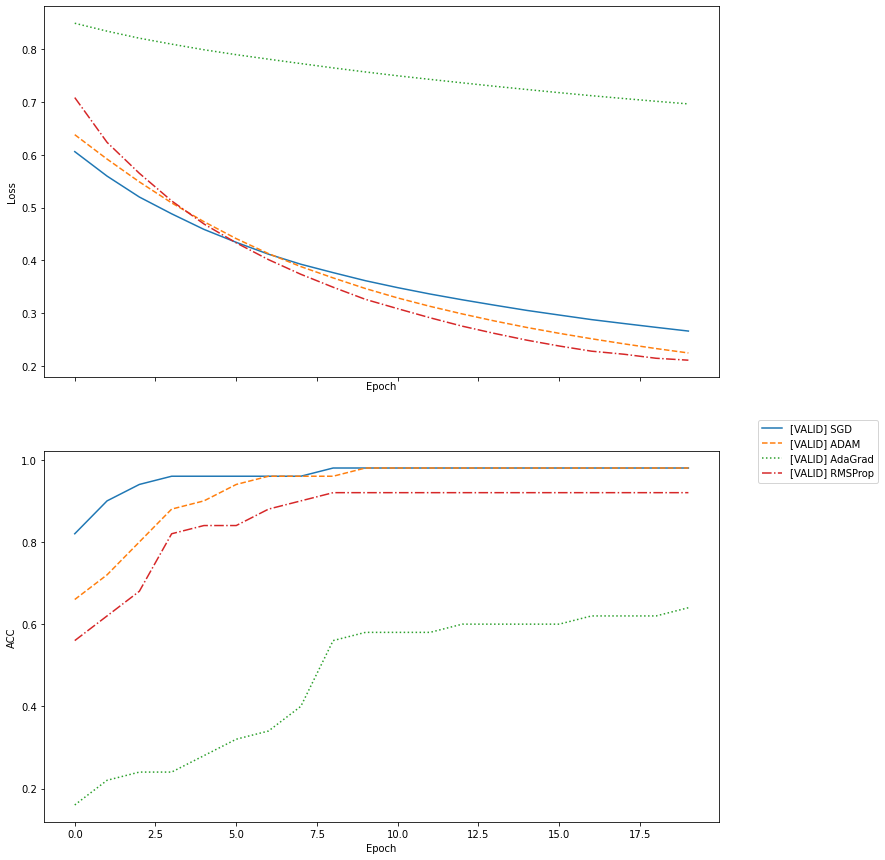

In [11]:
legend = ["[VALID] SGD", "[VALID] ADAM", "[VALID] AdaGrad", "[VALID] RMSProp"]
plot_loss_accuracy(historyList, legend, "valid")

----------
# Regularização dos Pesos (L2)

A princípio, estratégias que ajudem a reduzir _overfitting_ podem ser chamadas de **regularização**. Porém, aqui estamos usando o termo em um sentido mais estrito, que são **penalidades adicionadas à função de custo**. No geral, temos

$Loss_{total} = Loss + \lambda||W||$, 

Onde $W$ são os pesos do modelo e $||\dot||$ é uma função de medida (norma). O Keras permite definir um fator de regularização ($\lambda$) _por camada_ (veja código abaixo), e disponibiliza as medidas L1 e L2. Observe, no exemplo abaixo, o impacto de diferentes penalidades no _overfitting_ do modelo!

A documentação do Keras para regularizadores está em https://keras.io/regularizers/.

Uma explicação detalhada sobre o tema pode ser lida [neste blog post](https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea).


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


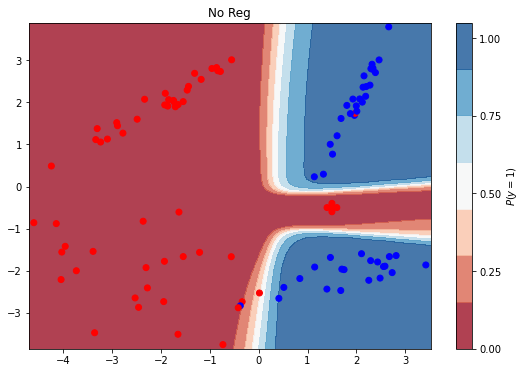

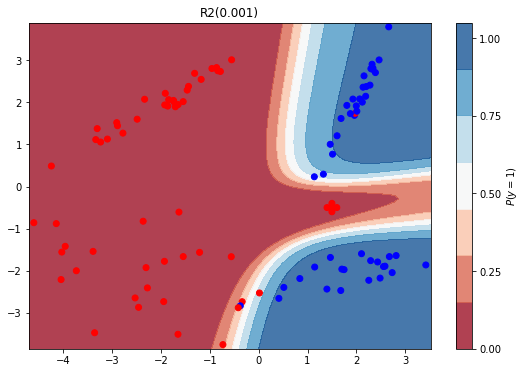

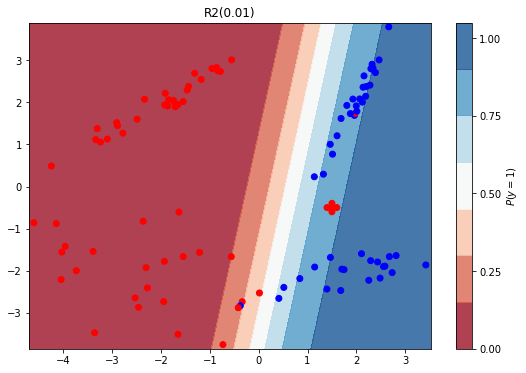

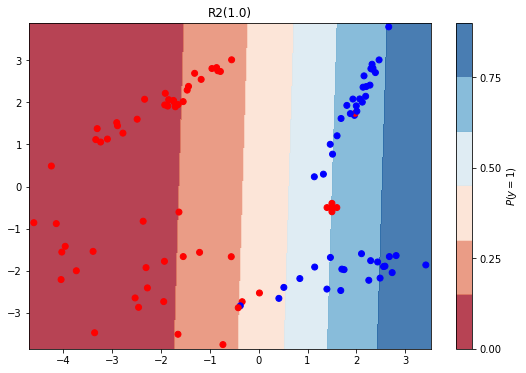

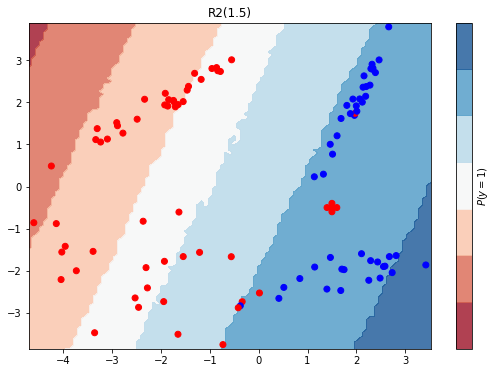

In [12]:
title = ["No Reg", "R2(0.001)", "R2(0.01)", "R2(1.0)", "R2(1.5)"]
# regularização de L2
regularization = [None, regularizers.l2(0.001), regularizers.l2(0.01), regularizers.l2(1.0), regularizers.l2(1.5)]
for i in list(range(len(regularization))):
    # Define o modelo
    model = Sequential()
    model.add(Dense(64, input_shape=(2,), activation='tanh', kernel_regularizer = regularization[i]))
    model.add(Dense(64, activation='tanh', kernel_regularizer = regularization[i]))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(keras.optimizers.Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_reg_train, Y_reg_train, verbose=0, epochs=100)
    plot_decision_boundary(lambda x: model.predict(x), X_reg_train, Y_reg_train, title[i])